<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/Transformer_Tutorial_%ED%99%A9%EC%A0%95%EC%9D%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import math
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple
import os
import copy
import time

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Embedding

If we have,
 \begin{pmatrix}
  \text{I} & \text{love} & \text{banana} \\
  \text{I} & \text{love} & \text{apple} \\
  \text{I} & \text{hate} & \text{banana}
 \end{pmatrix}




We can set vocab:

0. I
1. love
2. banana
3. apple
4. hate

Then input matrix(one-hot vector) will be:

\begin{pmatrix}
  [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0] \\
  [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0] \\
  [1,0,0,0,0], [0,0,0,0,1], [0,0,1,0,0]
 \end{pmatrix}


Then input matrix pass Embedding layer with weight $W$ and this weight matrix's shape will be [(5)vocab_size, (d)embedding dimension].

In [64]:
class Embeddings(nn.Module):
  def __init__(self, vocab_num, d_model):
    super(Embeddings,self).__init__()
    self.emb = nn.Embedding(vocab_num,d_model)
    self.d_model = d_model
  def forward(self, x):

    return self.emb(x) * math.sqrt(self.d_model)

# Encoding

In [65]:
class PositionalEncoding(nn.Module):

    def __init__(self, emb_dim, seq_len):
        super().__init__()

        self.encoding = torch.zeros(seq_len, emb_dim)
        self.encoding.requires_grad = False

        pos = torch.arange(0,seq_len).float().unsqueeze(dim=1)
        _2i = torch.arange(0,emb_dim,step=2).float()

        # self.encoding = (sequence_length, hidden_size)
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i/emb_dim)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i/emb_dim)))

    def forward(self, tensor):
        batch_size, sequence_length = tensor.size()

        # (sequence_length, hidden_size)
        return self.encoding[:sequence_length, :]

# Self-Attention

In [66]:
def self_attention(query, key, value, mask=None):
  key_transpose = torch.transpose(key,-2,-1)
  matmul_result = torch.matmul(query,key_transpose)
  d_k = query.size()[-1]
  attention_score = matmul_result/math.sqrt(d_k)

  if mask is not None:
    attention_score = attention_score.masked_fill(mask == 0, -1e20)

  softmax_attention_score = F.softmax(attention_score,dim=-1)
  result = torch.matmul(softmax_attention_score,value)

  return result, softmax_attention_score

class MultiHeadAttention(nn.Module):
    r"""
    Multi-Head Attention proposed in "Attention Is All You Need"
    Instead of performing a single attention function with d_model-dimensional keys, values, and queries,
    project the queries, keys and values h times with different, learned linear projections to d_head dimensions.
    These are concatenated and once again projected, resulting in the final values.
    Multi-head attention allows the model to jointly attend to information from different representation
    subspaces at different positions.

    MultiHead(Q, K, V) = Concat(head_1, ..., head_h) · W_o
        where head_i = Attention(Q · W_q, K · W_k, V · W_v)

    Args:
        dim (int): The dimension of model (default: 512)
        num_attention_heads (int): The number of attention heads. (default: 8)

    Inputs: query, key, value, mask
        - **query** (batch, q_len, d_model): tensor containing projection vector for decoders.
        - **key** (batch, k_len, d_model): tensor containing projection vector for encoders.
        - **value** (batch, v_len, d_model): tensor containing features of the encoded input sequence.
        - **mask** (-): tensor containing indices to be masked

    Returns: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features.
        - **attn** (batch * num_attention_heads, v_len): tensor containing the attention (alignment) from the encoders outputs.
    """
    def __init__(self, head_num , d_model, dropout = 0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % head_num == 0, "hidden_dim % num_attention_heads should be zero."

        self.head_num = head_num
        self.d_model = dim
        self.d_k = self.d_v = dim // head_num

        self.w_q = nn.Linear(dim,dim) # or self.w_q = nn.Linear(d_model, head_num * d_head)
        self.w_k = nn.Linear(dim,dim)
        self.w_v = nn.Linear(dim,dim)
        self.w_o = nn.Linear(dim,dim)

        self.self_attention = self_attention
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask = None):
      if mask is not None:
        # Same mask applied to all h heads.
        mask = mask.unsqueeze(1)

      batche_num = query.size(0)

      query = self.w_q(query).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
      key = self.w_k(key).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
      value = self.w_v(value).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)

      attention_result, attention_score = self.self_attention(query, key, value, mask)


      attention_result = attention_result.transpose(1,2).contiguous().view(batche_num, -1, self.head_num * self.d_k)


      return self.w_o(attention_result)

# Feedforward Network

In [67]:
class FeedForward(nn.Module):
  def __init__(self,d_model, dropout = 0.1):
    super(FeedForward,self).__init__()
    self.w_1 = nn.Linear(d_model, d_model*4)
    self.w_2 = nn.Linear(d_model*4, d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Encoder Layer

In [68]:
class Encoder(nn.Module):
  def __init__(self, d_model, head_num, dropout):
    super(Encoder,self).__init__()
    self.multi_head_attention = MultiHeadAttention(d_model= d_model, head_num = head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.feed_forward = FeedForward(d_model)
    self.layer_norm2 = nn.LayerNorm(d_model)

  def forward(self, input, mask):
    out = self.layer_norm1(input + self.multi_head_attention(input, input, input, mask))
    out = self.layer_norm2(out + self.feed_forward(out))

    return out


class Decoder(nn.Module):
  def __init__(self, d_model,head_num, dropout):
    super(Decoder,self).__init__()
    self.masked_multi_head_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.encoder_decoder_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm2 = nn.LayerNorm(d_model)

    self.feed_forward= FeedForward(d_model)
    self.layer_norm3 = nn.LayerNorm(d_model)


  def forward(self, target, encoder_output, target_mask, encoder_mask):
    # target, x, target_mask, input_mask
    x = self.layer_norm1(target, lambda x: self.masked_multi_head_attention(x, x, x, target_mask))
    x = self.layer_norm2(x, lambda x: self.encoder_decoder_attention(x, encoder_output, encoder_output, encoder_mask))
    x = self.layer_norm3(x, self.feed_forward)

    return x

# Model

In [69]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TransformerLM(nn.Module):
  def __init__(self, vocab_size, dim,  depth, max_seq_len, head_num, dropout= 0.1):
    super(TransformerLM,self).__init__()

    self.token_emb= nn.Embedding(vocab_size, dim)
    self.position_emb = PositionalEncoding(dim,max_seq_len)
    self.encoders = clones(Encoder(d_model=dim, head_num=head_num, dropout=dropout), depth)
    self.norm = nn.LayerNorm(dim)
    self.lm_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Linear(dim, vocab_size)
            )
  def subsequent_mask(self, size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

  def forward(self, input_ids, input_mask = None):
    if input_mask is None:
       input_mask = self.subsequent_mask(max_seq_len).to(device)

    x = self.token_emb(input_ids)
    x = x + self.position_emb(input_ids).type_as(x)

    for encoder in self.encoders:
      x = encoder(x, input_mask)
    x = self.norm(x)

    return self.lm_head(x)

# Dataset

In [70]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary() # to hold the mapping of words to indices

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            # for line in f:
            for i, line in enumerate(f):
                if i == 200:
                  break
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)
        # convert all words into their respective indices
        # Tokenize the file content
        ids = torch.LongTensor(tokens)
        token = 0
        with open(path, 'r') as f:
            # for line in f:
            for i, line in enumerate(f):
              if i == 200:
                break
              words = line.split() + ['<eos>']
              for word in words:
                  ids[token] = self.dictionary.word2idx[word]
                  token += 1

        # reshape the tensor into batches
        num_batches = ids.size(0) // batch_size # ids.size(0): size of the tensor along its first dimension, total number of tokens | get the num of full batches
        # many neural network architectures require all input data in a batch to have the same size or shape.
        ids = ids[:num_batches*batch_size] # slice to effectectively disregard the remainder
        return ids.view(batch_size, -1) # reshaping to have batch_size rows and enough columns for all tokens in each batch evenly

In [71]:
import matplotlib.pyplot as plt

# Hyper-parameters & Training

In [72]:
dim = 128
depth = 1
num_epochs = 5
batch_size = 20
max_seq_len = 15
learning_rate = 0.002
head_num = 8
sequence_lengths = [1, 2, 4, 8, 16, 25,36, 49, 64, 81, 100]  # sequence lengths to test


In [73]:
losses = []
times = []
epoch_losses = []
gradient_norms = []

vocab size:  1226
Sequence Length: 1, Avg Loss: 4.504317802403654, Time: 6.640115261077881
vocab size:  1226
Sequence Length: 2, Avg Loss: 4.356307451639856, Time: 2.985987424850464
vocab size:  1226
Sequence Length: 4, Avg Loss: 4.371745197262083, Time: 1.4848570823669434
vocab size:  1226
Sequence Length: 8, Avg Loss: 4.7160893780844555, Time: 0.7735543251037598
vocab size:  1226
Sequence Length: 16, Avg Loss: 4.863635178974697, Time: 0.38991236686706543
vocab size:  1226
Sequence Length: 25, Avg Loss: 5.558037519454956, Time: 0.24031615257263184
vocab size:  1226
Sequence Length: 36, Avg Loss: 5.754981946945191, Time: 0.18052220344543457
vocab size:  1226
Sequence Length: 49, Avg Loss: 5.922698020935059, Time: 0.12163186073303223
vocab size:  1226
Sequence Length: 64, Avg Loss: 6.066819667816162, Time: 0.09183835983276367
vocab size:  1226
Sequence Length: 81, Avg Loss: 6.225791263580322, Time: 0.06901359558105469
vocab size:  1226
Sequence Length: 100, Avg Loss: 6.303336191177368, 

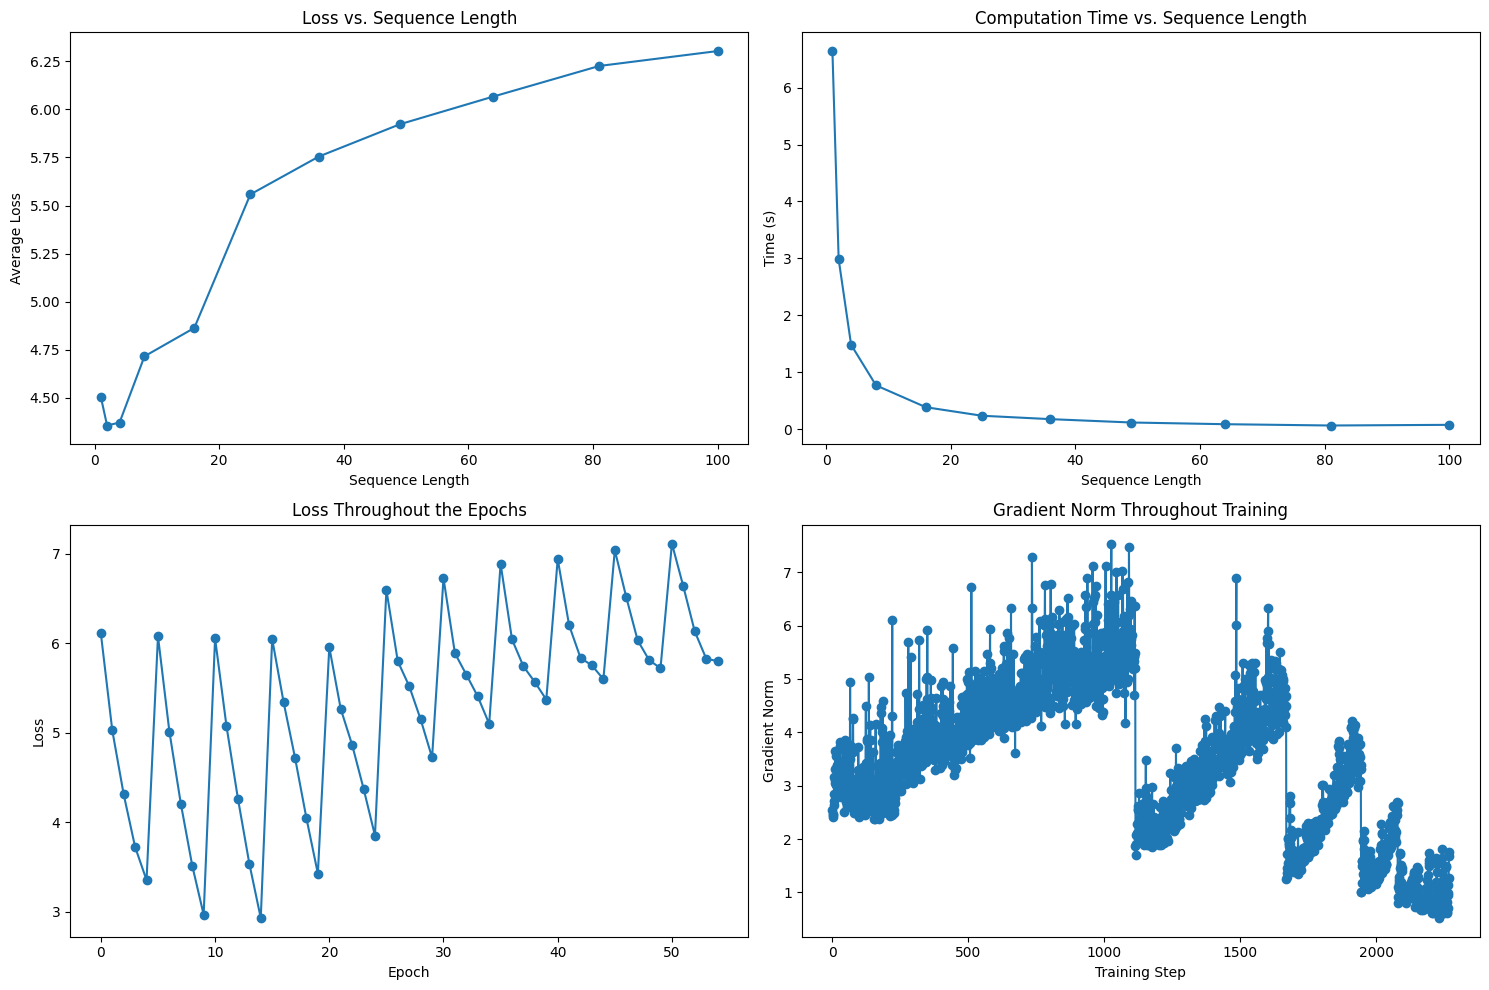

In [74]:
for max_seq_len in sequence_lengths:
    corpus = Corpus()
    ids = corpus.get_data('/content/drive/MyDrive/train.txt', batch_size)
    vocab_size = len(corpus.dictionary)
    num_batches = ids.size(1) // max_seq_len

    test_corpus = Corpus()
    test_ids = test_corpus.get_data('/content/drive/MyDrive/test.txt', batch_size)
    test_vocab_size = len(test_corpus.dictionary)
    test_num_batches = test_ids.size(1) // max_seq_len

    print("vocab size: ", vocab_size)

    model = TransformerLM(vocab_size, dim, depth, max_seq_len, head_num, dropout= 0.1).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    total_loss = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
            inputs = ids[:, i:i+max_seq_len].to(device)
            targets = ids[:, (i+1):(i+1)+max_seq_len].to(device)

            outputs = model(inputs)
            output_flat = outputs.view(-1, vocab_size)

            loss = criterion(output_flat, targets.reshape(-1))
            model.zero_grad()
            loss.backward()

            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norms.append(total_norm)

            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / num_batches)

    elapsed_time = time.time() - start_time
    avg_loss = total_loss / (num_batches * num_epochs)
    losses.append(avg_loss)
    times.append(elapsed_time)
    print(f"Sequence Length: {max_seq_len}, Avg Loss: {avg_loss}, Time: {elapsed_time}")

# Plotting
plt.figure(figsize=(15, 10))

# Plot Loss vs. Sequence Length
plt.subplot(2, 2, 1)
plt.plot(sequence_lengths, losses, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Average Loss')
plt.title('Loss vs. Sequence Length')

# Plot Computation Time vs. Sequence Length
plt.subplot(2, 2, 2)
plt.plot(sequence_lengths, times, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Computation Time vs. Sequence Length')

# Plot Loss Throughout the Epochs
plt.subplot(2, 2, 3)
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Throughout the Epochs')

# Plot Gradient Norm Throughout Training
plt.subplot(2, 2, 4)
plt.plot(gradient_norms, marker='o')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Throughout Training')

plt.tight_layout()
plt.show()
